<a href="https://colab.research.google.com/github/ProfessorDong/Deep-Learning-Course-Examples/blob/master/DRL_Examples/Cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Q-Network: Solving Cartpole with the Gymnasium Environment

Deep Q-Networks (DQNs) merge the principles of reinforcement learning with the capabilities of deep neural networks. By approximating Q-values using a deep neural network, DQNs are able to learn the optimal policy for a given problem. DQNs are particularly adept at handling problems with high-dimensional state spaces, such as image-based games. Utilizing the Gymnasium environment, we can effectively implement and test the Deep Q-Network algorithm to address the Cartpole problem.

In [1]:
!pip install gymnasium[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt

from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("CartPole-v1")

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
  from IPython import display

plt.ion()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Experience Replay Buffer

Transition = namedtuple('Transition',('state','action','next_state','reward'))

class ReplayMemory(object):
  def __init__(self, capacity):
    self.memory = deque([], maxlen=capacity)

  def push(self,*args):
    self.memory.append(Transition(*args))
    # Save a transition

  def sample(self, batch_size):
    return random.sample(self.memory, batch_size)

  def __len__(self):
    return len(self.memory)

In [4]:
class DQN(nn.Module):

  # Multilayer perceptron with three layers
  def __init__(self, n_observations, n_actions):
    super(DQN, self).__init__()
    self.layer1 = nn.Linear(n_observations,128)
    self.layer2 = nn.Linear(128, 128)
    self.layer3 = nn.Linear(128, n_actions)

  def forward(self, x):
    x = F.relu(self.layer1(x))
    x = F.relu(self.layer2(x))
    return self.layer3(x)

In [5]:
batch_size = 128 # number of transitions samples from the experience replay buffer
gamma = 0.99  # discount factor
eps_start = 0.9 # Starting value of epsilon
eps_end = 0.05
eps_decay = 1000 # rate of exponential decay of epsilon, higher means slower decay
tau = 0.005 # update rate of the target network
lr =  1e-4 # learning rate of AdamW optimizer

In [6]:
#@title Training

n_actions = env.action_space.n  # Get the number of actions from gym action space

state, info = env.reset()
n_observations = len(state) # Get the number of features in the state observations

# Target network is initialized with the same weights as the policy network
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=lr, amsgrad=True)

memory = ReplayMemory(10000)

# Keep track of the number of steps taken by the agent
steps_done = 0

# Input current state and return an action
def select_action(state):
  global steps_done
  sample = random.random()
  eps_threshold = eps_end + (eps_start - eps_end) * math.exp(-1. * steps_done / eps_decay)
  steps_done += 1
  if sample > eps_threshold:
    with torch.no_grad():
      # t.max(1) will return the largest column value of each row
      # second column on max result is index of where max element was found, so we pick action with the larger expected reward
      return policy_net(state).max(1)[1].view(1,1)
  else:
      return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

# It is used to keep track of the duration of each episode
episode_durations = []

# Visualize the training progress of the DQN
def plot_duration(show_result=False):
  plt.figure(1)
  durations_t = torch.tensor(episode_durations, dtype=torch.float)
  if show_result:
    plt.title("Result")
  else:
    plt.clf()
    plt.title('Training')
  plt.xlabel('Episode')
  plt.ylabel('Duration')
  plt.plot(durations_t.numpy())

  # Show the 100-episode moving average of the duration
  if(len(durations_t) >= 100):
    means = durations_t.unfold(0,100,1).mean(1).view(-1)
    means = torch.cat((torch.zeros(99),means))
    plt.plot(means.numpy())

  plt.pause(0.001) # Pause so that plots are updated

  if is_ipython:
    if not show_result:
      display.display(plt.gcf())
      display.clear_output(wait=True)
    else:
      display.display(plt.gcf())

In [7]:
def optimize_model():
  # Check if we have enough samples for a mini bacth
  if len(memory) < batch_size:
    return
    
  # Extract a mini-batch of transition (state,action,reward,next_state) from the experience reply memory

  transition = memory.sample(batch_size)
  
  # Convert batch-array of Transitions to Transition of batch-arrays
  batch = Transition(*zip(*transition))

  # Compute a mask of non-final states and concatenate the batch elements
  non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)),device=device,dtype=torch.bool)
  
  non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
  state_batch = torch.cat(batch.state)
  action_batch = torch.cat(batch.action)
  reward_batch = torch.cat(batch.reward)


  state_action_values = policy_net(state_batch).gather(1,action_batch)

  next_state_values = torch.zeros(batch_size,device=device)
  
  with torch.no_grad():
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]

  # Expect Q-value for each transition using the target network
  expected_state_action_values = (next_state_values * gamma) + reward_batch


  # Compute Huber loss
  # smooth approximation of the mean square error loss, less sensitive
  criterion = nn.SmoothL1Loss()
  loss = criterion(state_action_values,
                   expected_state_action_values.unsqueeze(1))

  # Optimize the model
  optimizer.zero_grad()
  loss.backward()

  # In-place gradient clipping
  # maximum value = 100 to prevent exploding gradient problem
  torch.nn.utils.clip_grad_value_(policy_net.parameters(),100)
  optimizer.step()

Complete


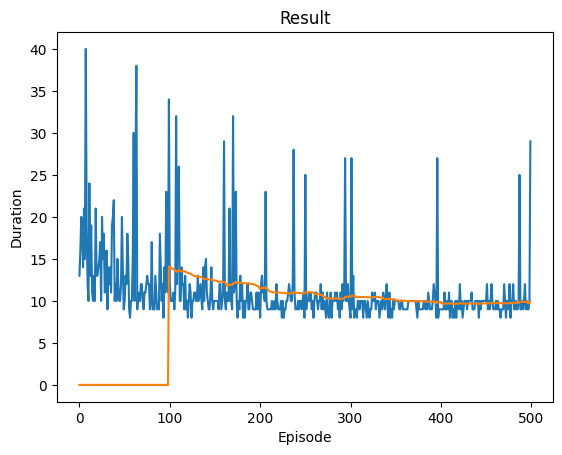

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [8]:
if torch.cuda.is_available():
  num_episodes = 1000
else:
  num_episodes = 500

# Iterate for episodes
for i_episode in range(num_episodes):
  # Intialize the environment and get its state
  state,info = env.reset()
  state = torch.tensor(state,dtype=torch.float32,
                       device=device).unsqueeze(0)
  for t in count():
    action = select_action(state)
    observation , reward , terminated , truncated ,_ = env.step(action.item())
    reward = torch.tensor([reward],device = device)

    # frame = env.render()
    # plt.imshow(frame)
    # plt.show()

    done  = terminated or truncated

    if  terminated:
      next_state = None
    else:
      next_state = torch.tensor(observation,dtype=torch.float32,device=device).unsqueeze(0)  

    # Store the transition in memory
    memory.push(state,action,next_state,reward)

    # Move to the next state
    state = next_state

    # Optimize
    optimize_model()

  # Soft update the target network's weights by blending policy network's weights and target network's weights using a hyperparameter tau
    target_net_state_dict  = target_net.state_dict()
    policy_net_state_dict  = target_net.state_dict()

    for key in policy_net_state_dict:
      target_net_state_dict[key] = policy_net_state_dict[key]*tau + target_net_state_dict[key]*(1 - tau)

    if done:
      episode_durations.append(t + 1)
      plot_duration()
      break

print('Complete')
plot_duration(show_result=True)
plt.ioff()
plt.show()    